# **Analyse et prétraitement**

<div class="alert alert-info">
Nous allons ici nous focaliser sur l'analyse et le traitement de base des images. L'étape de data augmentation sera directement intégrée lors de l'entraînement de notre modèle.
</div>

In [1]:
import matplotlib.pyplot as plt  # Visualisations
import numpy as np  # Manipulations d'array

# Importation, traitement et enregistrement d'images
from PIL import Image
from PIL.ImageFilter import MedianFilter
from PIL.ImageEnhance import Contrast
from PIL.ImageOps import autocontrast, equalize, pad, fit, grayscale

# Utilisé pour le ZCA Whitening
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob  # Récupération des emplacements de fichiers
import os  # Manipulations de fichiers
import shutil  # Pour supprimer un dossier non vide
from collections import Counter  # Pour compter les occurences des labels

## **A). Chargement des fichiers**

In [2]:
path = "dogs_small/"  # Localisation des images du dataset
data_path = glob(path+'*/*.jp*')  # Récupération des chemins de tous les fichiers
suffixe = "_proc"  # Suffixe à ajouter au dossier des images traitées

In [3]:
# Récupération des noms des dossiers (qui représentent les noms des labels)
# [len(path):] pour ne récupérer que les noms des dossiers, sans le chemin
list_labels = [os.path.dirname(dossier)[len(path):] for dossier in data_path]

# Récupération des noms de fichier (pour sauvegarde à la fin de nos traitements)
file_names = [os.path.basename(dossier) for dossier in data_path]

# Convertion des images en arrays
# img_array = [np.array(Image.open(ligne)) for ligne in data_path]

# Ouverture des images avec PIL.image
img_pil = [Image.open(ligne) for ligne in data_path]

# Récupération des dimensions des images
largeur = [ligne.size[0] for ligne in img_pil]
hauteur = [ligne.size[1] for ligne in img_pil]
pixels = [ligne.size[0] * ligne.size[1] for ligne in img_pil]

## **B). Caractéristiques du dataset**

In [4]:
print(f"Nombre de classes : {len(set(list_labels))}")
print(f"Nombre de fichiers : {len(file_names)}")

print("\nClasses et images associées : ")
occurrences = Counter(list_labels)
for label, count in occurrences.items():
    print(f"'{label}' : {count} images.")

Nombre de classes : 3
Nombre de fichiers : 589

Classes et images associées : 
'n02085620-Chihuahua' : 152 images.
'n02085782-Japanese_spaniel' : 185 images.
'n02085936-Maltese_dog' : 252 images.


### **Labels et fichiers**

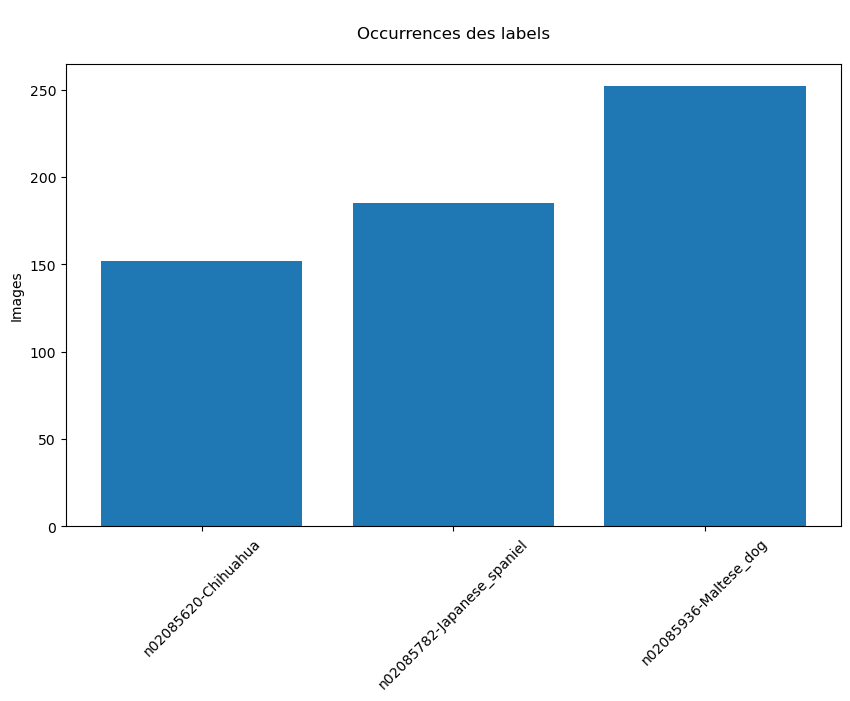

In [5]:
# On récupère les noms des labels et les occurences
# "*" dans zip() permet de passer en arguments séparés
# les paires clé-valeur renvoyées par occurrences.items()
labels, counts = zip(*occurrences.items())

# Graphique
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.ylabel('Images')
plt.xticks(rotation=45, ha='center')
plt.title('\nOccurrences des labels\n')
plt.show()


### **Nombre de pixels des images**

Pixels maximale : 7990272
Pixels minimale : 12500
Pixels moyenne : 181277


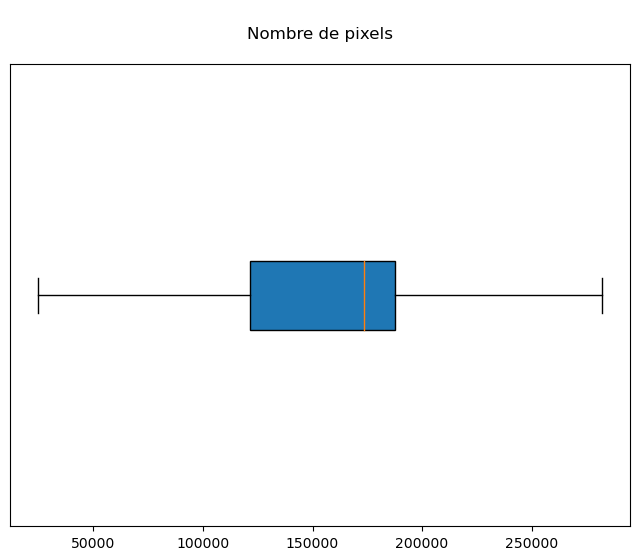

In [6]:
print(f"Pixels maximale : {max(pixels)}")
print(f"Pixels minimale : {min(pixels)}")
print(f"Pixels moyenne : {sum(pixels)/len(pixels):.0f}")

plt.figure(figsize=(8, 6))
plt.boxplot(pixels, vert=False, showfliers=False, patch_artist=True)
plt.title('\nNombre de pixels\n')
plt.yticks([])
plt.show()

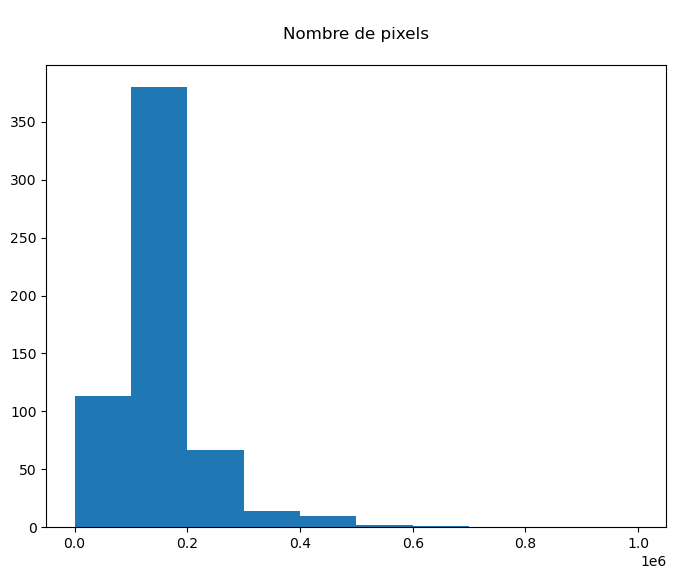

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(pixels, 10, range=(0, 1e6))
plt.title('\nNombre de pixels\n')
plt.show()

### **Largeurs**

Largeur maximale : 3264
Largeur minimale : 120
Largeur moyenne : 434


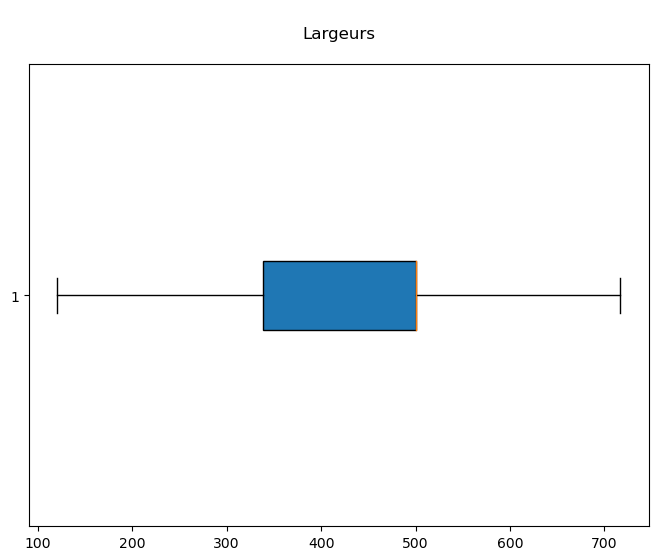

In [8]:
print(f"Largeur maximale : {max(largeur)}")
print(f"Largeur minimale : {min(largeur)}")
print(f"Largeur moyenne : {sum(largeur)/len(largeur):.0f}")

plt.figure(figsize=(8, 6))
plt.boxplot(largeur, vert=False, showfliers=False, patch_artist=True)
plt.title('\nLargeurs\n')
plt.show()

### **Hauteurs**

Hauteur maximale : 2448
Hauteur minimale : 100
Hauteur moyenne : 376


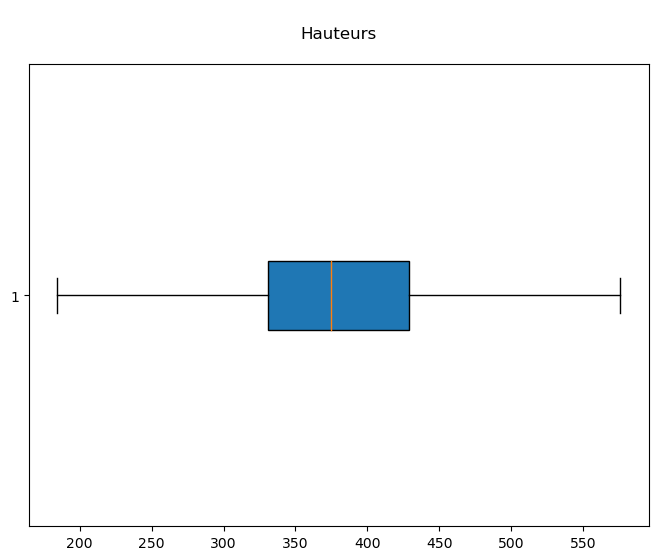

In [9]:
print(f"Hauteur maximale : {max(hauteur)}")
print(f"Hauteur minimale : {min(hauteur)}")
print(f"Hauteur moyenne : {sum(hauteur)/len(hauteur):.0f}")

plt.figure(figsize=(8, 6))
plt.boxplot(hauteur, vert=False, showfliers=False, patch_artist=True)
plt.title('\nHauteurs\n')
plt.show()

## **C). Traitement des images**

### **Fonction pour afficher les images et leur histogramme**

In [10]:
def image_shower(img):
    """
    Cette fonction permet d'afficher une image
    et ses histogramme (classique et cumulé)

    Prend en entrée une image PIL ou un array    
    """
    # Si l'image entrée n'est pas un array,
    # on le convertit
    if not isinstance(img, np.ndarray):
        img = np.array(img)

    # Création d'une figure qui comportera l'image et les deux histogrammes
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # Afficher l'image à gauche
    ax1.imshow(np.array(img), cmap='gray')  # cmap='gray' pour que l'image soit affichée en noir et blanc
                                            # s'il n'y a qu'un seul canal. Ce paramètre est ignoré si l'image est en RGB
    #ax1.axis('off')  # Si on souhaite masquer les axes sur l'image

    # Générer et afficher l'histogramme à droite
    ax2.hist(np.array(img).flatten(), bins=range(256))
    ax2.set_title('Histogramme')
    ax2.set_xlabel('Couleur')
    ax2.set_ylabel('Fréquence')
    ax2.set_xlim(0, 255)

    # Générer et afficher l'histogramme à droite
    ax3.hist(np.array(img).flatten(), bins=range(256), density=True, cumulative=True)
    ax3.set_title('Histogramme cumulé normalisé')
    ax3.set_xlabel('Couleur')
    ax3.set_ylabel('Fréquence')
    ax3.set_xlim(0, 255)

    plt.show()

### **Exemple d'image avant traitement**

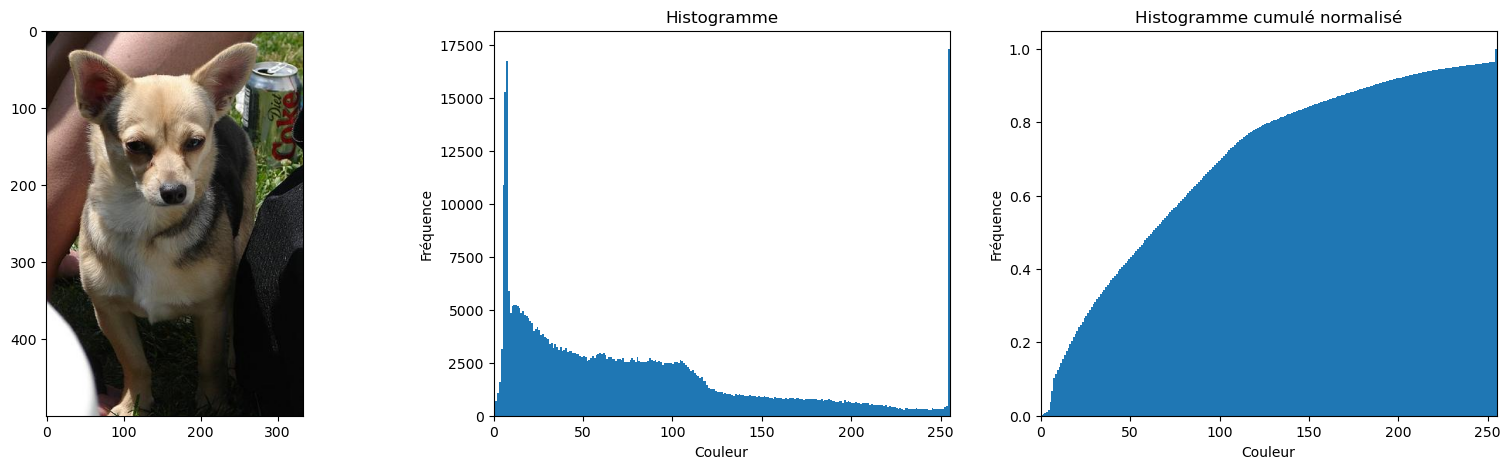

In [11]:
image_shower(img_pil[0])

### **1). Traitements génériques**

#### **Options de traitement**

In [12]:
# Redimentionnement
out_size = (150, 150)
resize_mod = "fit"  # Autre option "pad"

# Denoising
denoise = True

# Contraste supplémentaire
contrast = False
contrast_amount = 1.1

# Passage en niveau de gris
gray = False

#### **Redimensionnement**

Avant d'être passées dans nos modèles, il est préférable de redimensionner nos images, en format carré. Pour ce faire, deux approches sont possibles : 
- Approche *"fit"* : l'image est redimensionnée, l'aspect ratio est conservé, si besoin l'image est recadrée pour correspondre aux dimensions de sortie.<br>
**Avantage :** pas d'ajout de bruit ; **Défaut :** perte d'information
- Approche *"pad"* : l'image est redimensionnée, l'aspect ratio est conservé, si besoin l'image est comblée de noir pour correspondre aux dimensions de sortie.<br>
**Avantage :** pas de perte d'information ; **Défaut :** ajoute de bruit (remplissage noir)

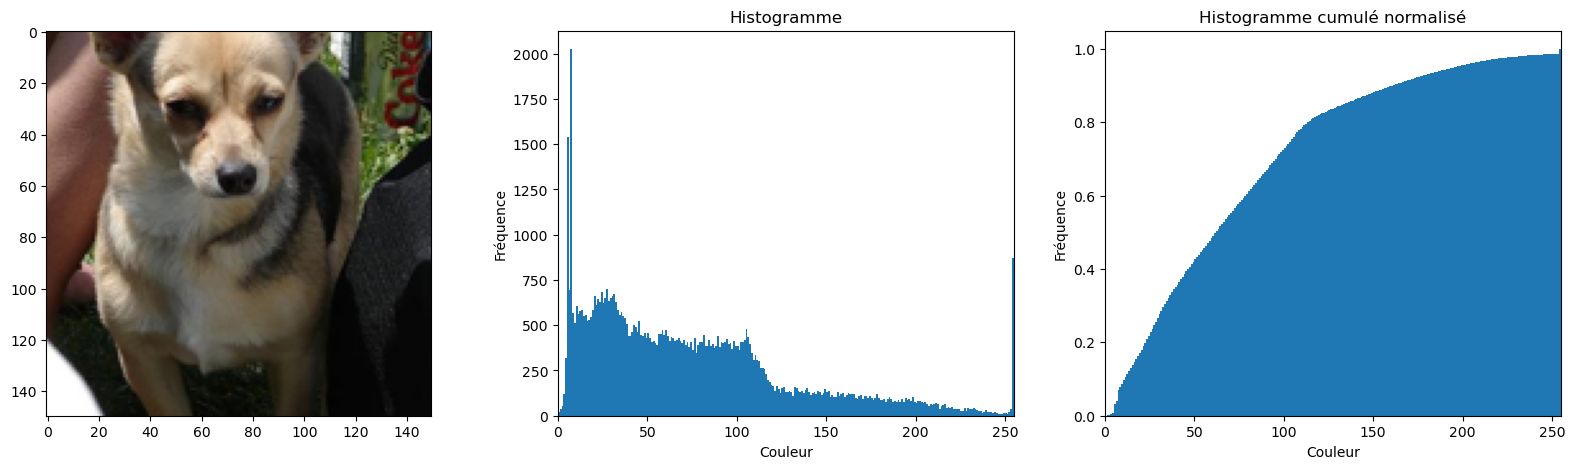

In [13]:
if resize_mod:
    for i in range(len(img_pil)):
        img = img_pil[i]
        if resize_mod == "fit":
            img = fit(img, out_size, bleed=0.0, centering=(0.5, 0.5))
        
        if resize_mod == "pad":
            img = pad(img, out_size, color=None, centering=(0.5, 0.5))
        
        # On remplace l'image d'origine par l'image traitée
        img_pil[i] = img

    # Exemple d'image après traitement 
    image_shower(img_pil[0])

else:
    print("Pas de redimensionnement.")

#### **Débruitage**

Débruitage de l'image à l'aide d'un filtre médian (non-linéaire) : la valeur de chaque pixel est remplacée par la médiane de son voisinage. 

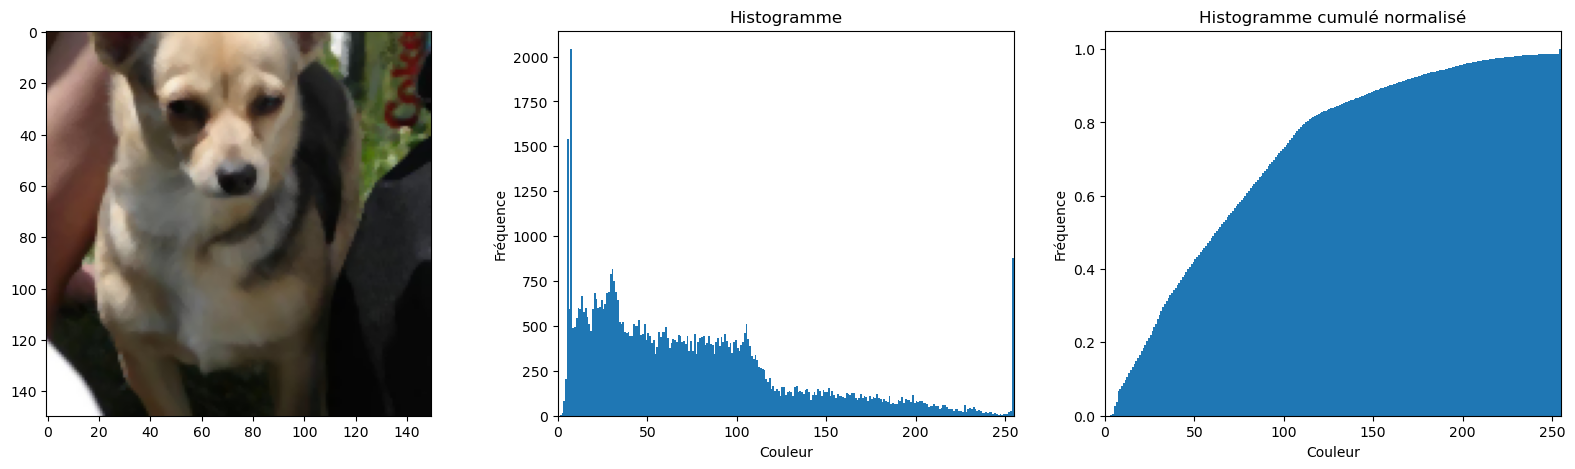

In [14]:
if denoise:
    
    for i in range(len(img_pil)):

        img = img_pil[i]

        # Denoising léger
        img = img.filter(MedianFilter(3))

        # On remplace l'image d'origine par l'image traitée
        img_pil[i] = img        

    image_shower(img_pil[0])

else:
    print("Pas de débruitage.")

#### **Égalisation des histogrammes**

Le processus d'égalisation de l'histogramme fonctionne en redistribuant les intensités de pixel de manière à ce que l'histogramme cumulé soit uniforme. Cela signifie que les niveaux d'intensité d'origine, qui pourraient être concentrés dans certaines plages, sont étalés sur toute la plage des intensités possibles. En résultat, les zones sombres et claires de l'image peuvent apparaître plus distinctes.

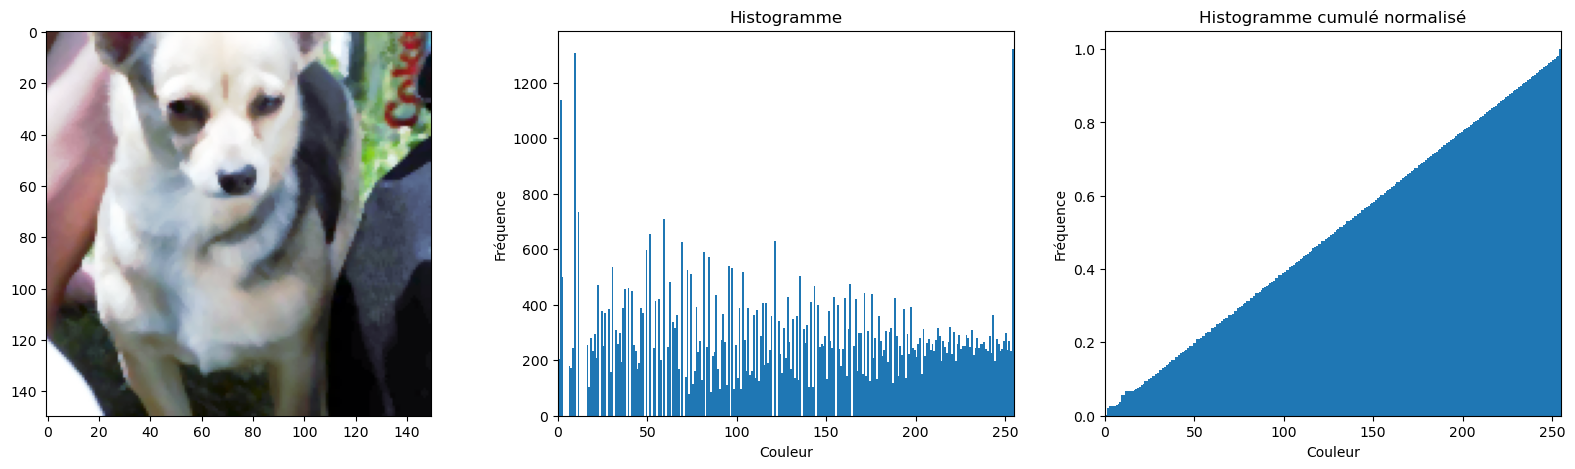

In [15]:
for i in range(len(img_pil)):

    img = img_pil[i]

    img = equalize(img)
    
    # On remplace l'image d'origine par l'image traitée
    img_pil[i] = img

image_shower(img_pil[0])

#### **Contraste**

Le traitement *autocontrast* permet de normaliser le contraste de l'image. L'effet n'est donc visibile que sur les images dont le contrast serait trop faible ou trop fort.

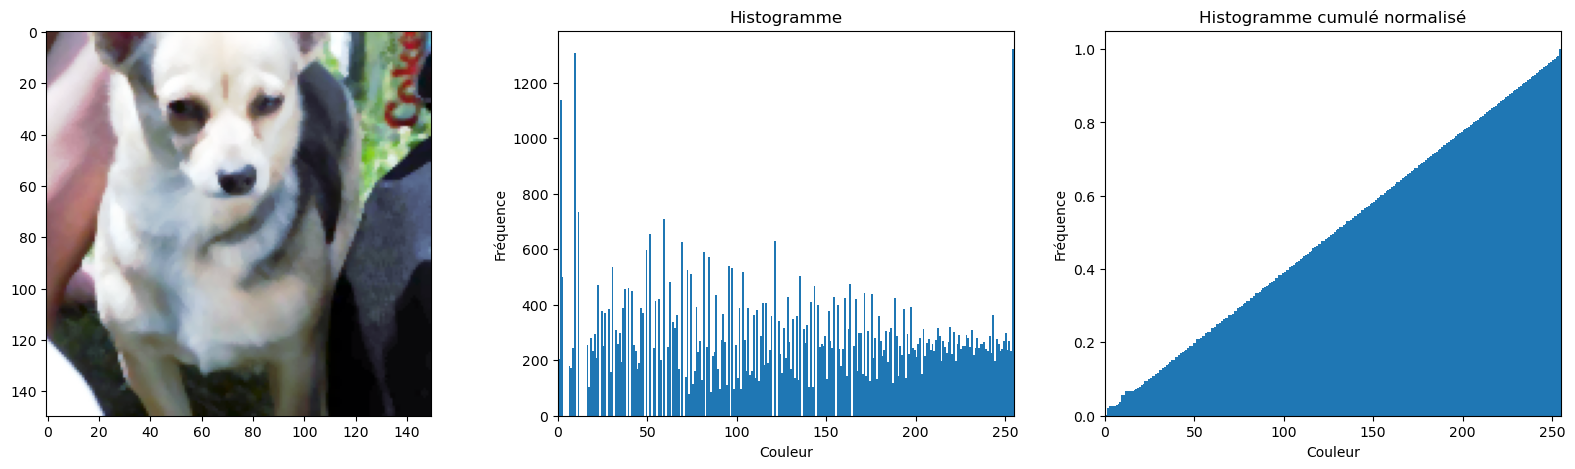

In [16]:
for i in range(len(img_pil)):

    img = img_pil[i]

    img = autocontrast(img)

    # Ajout de contraste supplémentaire
    if contrast:
        img = Contrast(img).enhance(contrast_amount)

    # On remplace l'image d'origine par l'image traitée
    img_pil[i] = img

# Exemple d'image après traitement 
image_shower(img_pil[0])

#### **Passage en niveau de gris**

Le passage en niveau de gris permet de fortement réduire la dimensionnalité de nos données, permettant d'accélérer les calculs lors du passage des images dans nos modèles. La contrepartie est une perte d'information, puisque les images n'ont plus de couleur.

In [17]:
if gray:
    for i in range(len(img_pil)):

        img = img_pil[i]

        img = grayscale(img)

        # On remplace l'image d'origine par l'image traitée
        img_pil[i] = img

    
    image_shower(img_pil[0])

else:
    print("Pas de niveau de gris.")

Pas de niveau de gris.


### **Exemple d'image après tous les traitements**

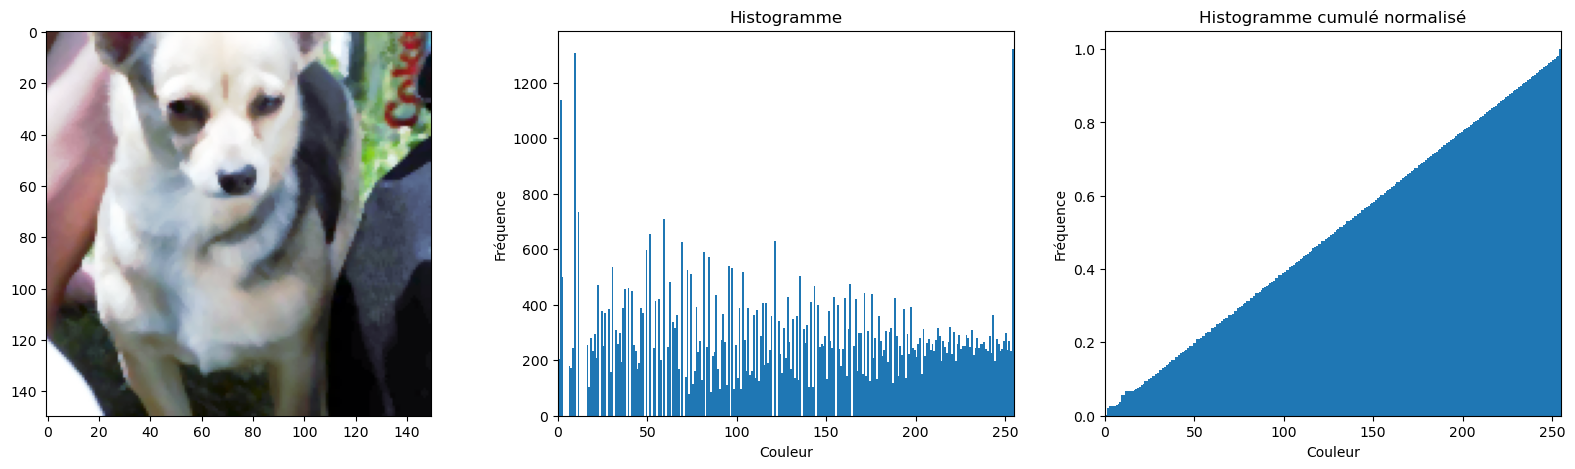

In [18]:
image_shower(img_pil[0])

### **2). ZCA Whitening**

#### **Conversion de notre liste d'image PIL en array**

In [19]:
image_array_list = [np.array(img) for img in img_pil]
img_array = np.stack(image_array_list)

# Si l'image est en niveau de gris, un reshape doit être fait
if gray:
    img_array = img_array.reshape((-1, out_size[0], out_size[1], 1))
    
print(f"Dimensions de l'array d'images : {img_array.shape}")

Dimensions de l'array d'images : (589, 150, 150, 3)


#### **Entraînement du modèle**

In [20]:
X = img_array

datagen = ImageDataGenerator(featurewise_center=True,  # Centrer les valeurs sur 0 (nécessaire que le zca_whitening)
                             featurewise_std_normalization=False,  # False requis pour zca_whitening=True
                             zca_whitening=True
)
# Entraînement
datagen.fit(X)

In [21]:
whitenized = datagen.flow(X, batch_size=9, shuffle=False).next()

#### **Exemples d'images traitées**

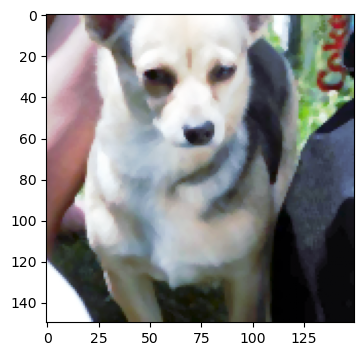

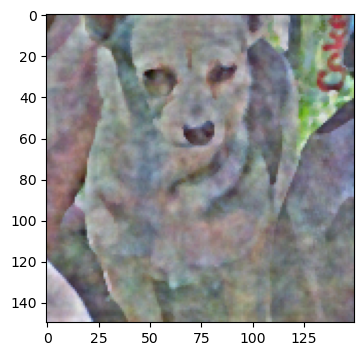

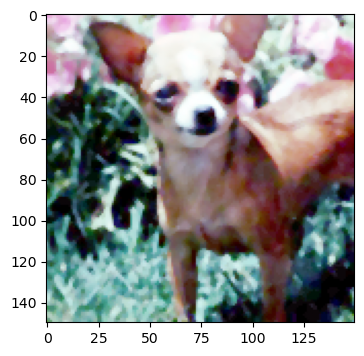

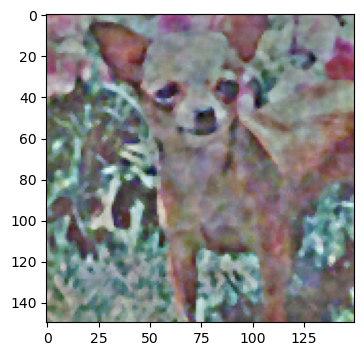

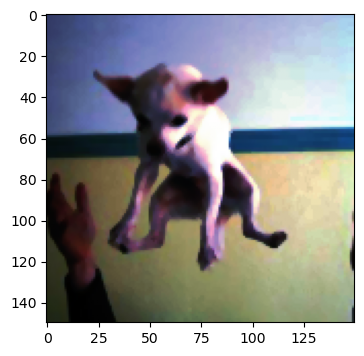

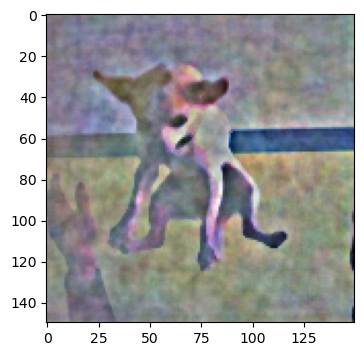

In [22]:
size_show = out_size + (3,)  # Dimensions auxquelles on a redimensionné 
                             # les images lors de nos prétraitements
                             # et on ajoute le nombre de caneaux (3 pour RGB)

if gray:
    size_show = out_size + (1,)

def show(i):
    i = i.reshape(size_show)
    m, M = i.min(), i.max()

    img = (i - m) / (M - m)
   
    plt.figure(figsize = (4, 4))
    plt.imshow(img, cmap='gray')  # cmap='gray' pour que l'image soit affichée en noir et blanc
                                  # s'il n'y a qu'un seul canal. Ce paramètre est ignoré si l'image est en RGB
    plt.show()

for i in range(3):
    show(X[i])
    show(whitenized[i])

## **D). Enregistrement des images traitées**

In [23]:
# im = Image.fromarray(data["img_array"][0])
# im.save("your_file.jpeg")

save_file = False

if save_file:

    # Dossier de sauvegarde : même nom que celui d'origine + suffixe
    dossier = path[:-1]+suffixe

    # Si le dossier existe déjà (précédente sauvagarde)
    # suppression du dossier et de son contenu avec shutil
    if os.path.exists(path[:-1]+suffixe):
        shutil.rmtree(dossier)

    # Création du dossier
    os.mkdir(dossier)

    # Récupération du nom des labels
    unique_labels = list(set(list_labels))

    # Création des sous dossiers qui auront le nom de chaque label
    for i in range(len(unique_labels)):
        os.mkdir(path[:-1]+suffixe+"/"+unique_labels[i])

    # Enregistrement de chaque image dans son dossier respectif
    for i in range(len(img_pil)):
        img_pil[i].save(dossier+"/"+list_labels[i]+"/"+file_names[i])